In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import pandas as pd
import numpy as np
import matplotlib
import threading
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
matplotlib.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
from sklearn import preprocessing
import time
import inspect
sns.set_context('talk')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano

In [2]:
workingDirectory = '/home/h1bennet/liverStrains/results/181009_kupffer_ly6c_tba/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

### Order of samples for plotting

In [3]:
# make folder for figures
if not os.path.isdir('./figures'):
    os.mkdir('./figures')

### QC

In [4]:
%%bash
if [ ! -d ./qc_rna/ ]; then mkdir ./qc_rna; fi

In [5]:
qc_rna = ngs_qc('./tag_directories_rna/', 'rna')

C57B6J_BMDM_RNA_GW3965_1uM_C573A_CMB_l20180625_CACCGG does not contain a mapping log file
C57B6J_BMDM_RNA_GW3965_1uM_C573A_CMB_l20180625_CACCGG does not contain a mapping log file
C57B6J_BMDM_RNA_GW3965_1uM_C573A_CMB_l20180625_CACCGG does not contain a mapping log file
C57B6J_BMDM_RNA_GW3965_1uM_C573A_CMB_l20180625_CACCGG does not contain a mapping log file
C57B6J_BMDM_RNA_GW3965_1uM_C573A_CMB_l20180625_CACCGG does not contain a mapping log file
C57B6J_BMDM_RNA_GW3965_1uM_C573A_CMB_l20180625_CACCGG does not contain a mapping log file
C57B6J_BMDM_RNA_GW3965_1uM_C573A_CMB_l20180625_CACCGG does not contain a mapping log file
C57B6J_BMDM_RNA_GW3965_1uM_C573A_CMB_l20180625_CACCGG does not contain a mapping log file
C57B6J_BMDM_RNA_GW3965_1uM_C573A_CMB_l20180625_CACCGG does not contain a mapping log file
C57B6J_BMDM_RNA_GW3965_1uM_C573A_CMB_l20180625_CACCGG does not contain a mapping log file
C57B6J_BMDM_RNA_GW3965_1uM_C573A_CMB_l20180625_CACCGG does not contain a mapping log file
C57B6J_BMD

/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 432x288 with 0 Axes>

### Create count files

In [6]:
# %%bash
# # if directories don't exist, create them
# if [ ! -d ./expression/ ]; then mkdir ./expression; fi

# analyzeRepeats.pl rna mm10 -count exons -condenseGenes -raw -d ./tag_directories_rna/* > ./expression/rna_exp_raw.tsv
# # analyzeRepeats.pl rna mm10 -count exons -condenseGenes -d ./tag_directories_rna/* > ./expression/rna_exp.tsv
# analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d ./tag_directories_rna/* > ./expression/rna_exp_rpkm.tsv

In [7]:
# read in rpkm
rpkm = pd.read_csv('./expression/rna_exp_rpkm.tsv', sep='\t')
rpkm.set_index(rpkm.columns.values[0], inplace=True)
rpkm.index.rename('refseqID', inplace=True)
# set rpkm index
mm10_gene = rpkm['Annotation/Divergence'].str.split('|').str[0]

# clean up column names
# rename rpkm columns
rpkm = rpkm.rename(columns=dict(zip(rpkm.iloc[:, 7:].columns.values,
                                    pd.Series(rpkm.iloc[:, 7:].columns.values).str[:-5].str.split('/').str[-1])))
# change index to gene names
rpkm['gene'] = mm10_gene
rpkm = rpkm.reset_index().set_index('gene').drop(labels='refseqID', axis=1)

# filter genes with length < 250 bp
rpkm = rpkm.loc[rpkm.Length >= 250, :]

# drop pooled sample
rpkm = rpkm.drop(columns=['C57B6J_BloodLy6cHi_RNA_NoTx_Pooled_MS_l20171111_CGATGT']) # ,
#                           'C57Bl6_BloodLy6cHi_RNA_20wkControlDiet_JSSTDT_Rep1_JSS_s20180814_CGATGT',
#                           'C57Bl6_BloodLy6cHi_RNA_20wkControlDiet_JSSTDT_Rep2_JSS_s20180814_TGACCA'])

# filter genes expressed under 4 rpkm in all samples 
rpkm_filt = rpkm.loc[(rpkm.iloc[:, 7:] > 4).all(1), :]

In [8]:
# make group labels
cell = rpkm.iloc[:, 7:].columns.to_series().str.split('_').str[1]
diet = rpkm.iloc[:, 7:].columns.to_series().str.split('_').str[3]

### Make figures for PCA

In [9]:
# make folder to store expression figures
if not os.path.isdir('./figures'):
    os.mkdir('./figures')
if not os.path.isdir('./figures/expression_figures'):
    os.mkdir('./figures/expression_figures')

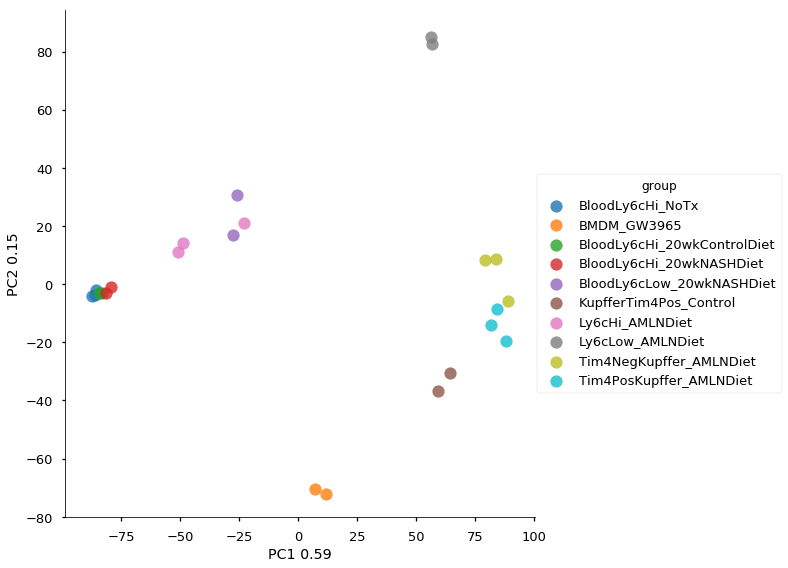

In [10]:
pca, exp_var, weights = pca_rpkm_mat(rpkm.iloc[:, 7:],
             group_labels=cell+'_'+diet,
             n_pca=10)
plt.savefig('./figures/expression_figures/rna_pca.pdf', bbox_inches='tight')

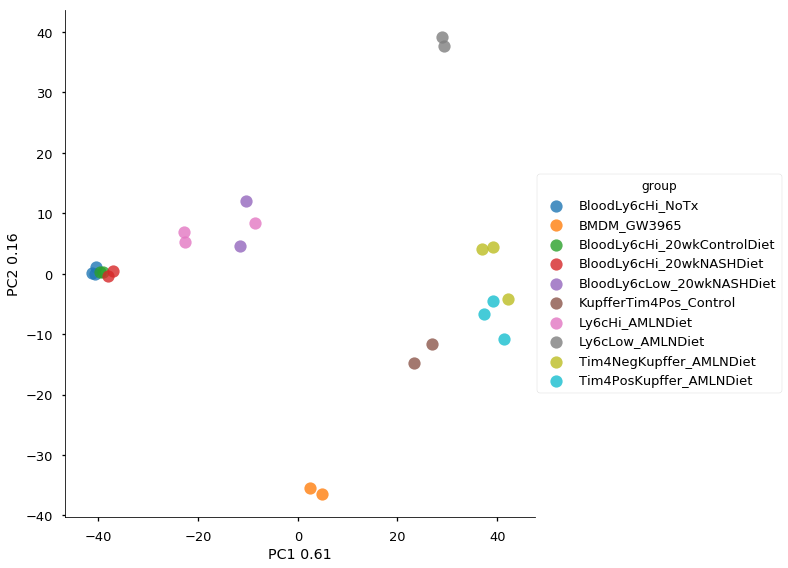

In [11]:
pca, exp_var, weights = pca_rpkm_mat(rpkm_filt.iloc[:, 7:],
             group_labels=cell+'_'+diet,
             n_pca=10)
plt.savefig('./figures/expression_figures/rna_pca_filtered.pdf', bbox_inches='tight')

Quantile normalized PCA

In [12]:
rpkm_quant = quantile_normalize_df(rpkm.iloc[:, 7:])
rpkm_quant_filt = quantile_normalize_df(rpkm_filt.iloc[:, 7:])

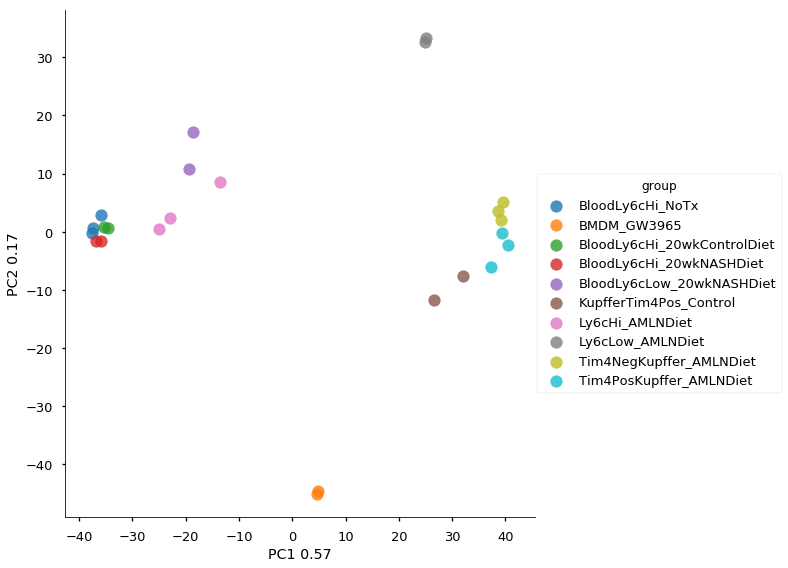

In [13]:
pca, exp_var, weights = pca_rpkm_mat(rpkm_quant_filt,
             group_labels=cell+'_'+diet,
             n_pca=10)
plt.savefig('./figures/expression_figures/rna_pca_filtered_quantile_normalized.pdf', bbox_inches='tight')

Interestingly it looks like Ly6cLow hepatic monocytes are the most similar on PC1 to kupffer cells

### Look at weights vs expression

In [14]:
# import motif weights
motif_meta = pd.read_csv('/home/h1bennet//code/abtba/motif_metadata.tsv',
                         sep='\t',
                         index_col=0)
# drop duplicated index
motif_meta = motif_meta[~motif_meta.index.duplicated(keep='first')]

In [15]:
# record motif mean pval in dict
motif_pval_dict = {}
# record tf mean pval in dict
tf_pval_dict = {}
# record mean motif weight
motif_weight_dict = {}
# record mean tf weight
tf_weight_dict = {}
for f in os.listdir('./abtba_output/'):
    if 'significance.tsv' in f and not 'gene' in f:
        # read in signifance values using pandas
        pval_frame = pd.read_csv('./abtba_output/' + f, sep='\t', index_col=0)
        #drop duplicates
        pval_frame
        # merge with motif metadata to get list of gene names
        pval_frame['genes'] = motif_meta.Gene
        pval_frame = pval_frame[['genes', '0']]
        # take the mean across cross validation iterations
        mean_pval = pval_frame.iloc[:, 1:].mean(axis=1) 
        # read in weight values using pandas
        weight_frame = pd.read_csv(
            './abtba_output/'+f.replace('significance', 'coefficients'),
            sep='\t', index_col=0)
               # merge with motif metadata to get list of gene names
        weight_frame['genes'] = motif_meta.Gene
        weight_frame = weight_frame[['genes', '0']]
        mean_weight = weight_frame.iloc[:, 1:].mean(axis=1) 
        # sample
        sample = '_'.join(f.split('_')[0:4])
        # record mean motif weight/pval
        motif_pval_dict[sample] = mean_pval
        motif_weight_dict[sample] = mean_weight
        # convert motif/score frame to a tf/score frame
        sample_tf_pval_dict = {}
        sample_tf_weight_dict = {}
        for index, row in pval_frame.iterrows():
            for tf in re.split('\||::', str(row.genes)):
                try:
                    if sample_tf_pval_dict[tf.upper()] > mean_pval[index]:
                        sample_tf_pval_dict[tf.upper()] = mean_pval[index]
                        sample_tf_weight_dict[tf.upper()] = mean_weight[index]
                except KeyError: 
                    sample_tf_pval_dict[tf.upper()] = mean_pval[index]
                    sample_tf_weight_dict[tf.upper()] = mean_weight[index]
        tf_pval_dict[sample] = sample_tf_pval_dict
        tf_weight_dict[sample] = sample_tf_weight_dict
# create data frames
# motifs
motif_mean_pval_frame = pd.DataFrame(motif_pval_dict,
                               index=motif_pval_dict[list(motif_pval_dict.keys())[0]].index.values)
motif_mean_pval_frame = motif_mean_pval_frame[motif_mean_pval_frame.isnull().max(axis=1)==False]

tf_mean_pval_frame = pd.DataFrame(tf_pval_dict)
tf_mean_pval_frame = tf_mean_pval_frame[tf_mean_pval_frame.isnull().max(axis=1)==False]
# weights
motif_mean_weight_frame = pd.DataFrame(motif_weight_dict,
                               index=motif_weight_dict[list(motif_weight_dict.keys())[0]].index.values)
motif_mean_weight_frame = motif_mean_weight_frame[motif_mean_weight_frame.isnull().max(axis=1)==False]

tf_mean_weight_frame = pd.DataFrame(tf_weight_dict)
tf_mean_weight_frame = tf_mean_weight_frame[tf_mean_weight_frame.isnull().max(axis=1)==False]

tf_mean_pval_frame.to_csv('./tf_mean_pval.tsv', sep='\t')
tf_mean_weight_frame.to_csv('./tf_mean_weight.tsv', sep='\t')

### Select motifs of interest for each cell

set order of samples

In [16]:
# define sample order for plotting
samp_order=['ncorwt_bloodly6chi_controldiet_0wk',
            'ncorwt_bloodly6clo_nashdiet_20wk',
            'ncorwt_bloodly6chi_nashdiet_20wk',
            'ncorwt_liverly6clo_nashdiet_30wk',
            'ncorwt_liverly6chi_nashdiet_30wk',
            'ncorwt_kupffer_controldiet_0wk',
            'ncorwt_kupffertim4neg_nashdiet_21wk',
            'ncorwt_kupffertim4pos_nashdiet_21wk']

Two options:
* just filter based on log10p values
* also filter on fold change to highlight TFs that are actually different between conditions

In [17]:
pseudocount = 1e-50 # pseudocount for calculating logfold change
treatments = motif_mean_weight_frame.columns
treatment_orientedPvals_dict = {}
# create treatement oriented p val frame
for treatment in treatments:
    # retrieve pval and weights cooresponding to treatment
    pvals = motif_mean_pval_frame[treatment]
    weights = motif_mean_weight_frame[treatment]
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    # store in dict
    treatment_orientedPvals_dict[treatment] = oriented_pvals

# create data frame
frame = pd.DataFrame(treatment_orientedPvals_dict, index = motif_mean_pval_frame.index.values)

# filter frame for only values with a positively correlated
# log10p > 2
frame = frame[frame.max(axis=1) > 2]

# plot only motifs with absolute log likelihood ratio >= 2
filtered_frame = frame[((frame.max(axis=1) - frame.min(axis=1)).abs() >= 2)]
filtered_frame = filtered_frame.loc[:, :]

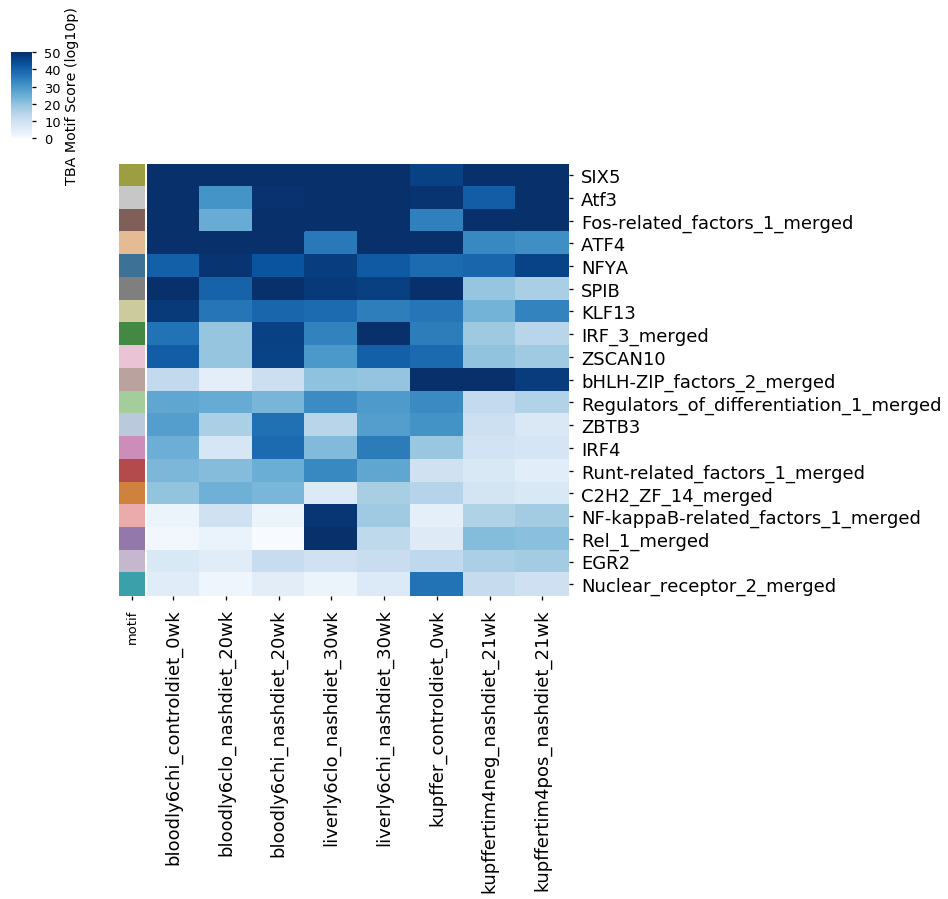

In [18]:
n_motifs = 10
motif_set = set()

# select top n motifs for each cell
for cell in filtered_frame.columns.values:
    motif_set.update(filtered_frame[cell].sort_values(ascending=False).index.values[:n_motifs])

# make dictionary of motif colors
motif_color = dict( zip(motif_set, sns.color_palette('tab20', n_colors=len(motif_set), desat=0.6).as_hex()) )
motif_color_series = pd.Series(motif_color, name='motif')

top_motif_frame = filtered_frame.loc[motif_set, :]
top_motif_frame['mean'] = top_motif_frame.mean(1)
top_motif_frame.sort_values('mean', ascending=False, inplace=True)
top_motif_frame.drop(columns='mean', inplace=True)

top_motif_frame.columns = top_motif_frame.columns.to_series().str.split('_').str[1:].str.join('_')

    
# create heatmap
hm = sns.clustermap(
    top_motif_frame.loc[:, ['_'.join(i.split('_')[1:]) for i in samp_order]],
    vmin=0,
    vmax=50,
    cmap='Blues',
    # square=True,
    # ax=ax,
    cbar_kws={'label': 'TBA Motif Score (log10p)'},
    row_colors=motif_color_series,
    row_cluster=False,
    col_cluster=False)

plt.setp(hm.ax_heatmap.yaxis.get_majorticklabels(), fontsize=18)
plt.setp(hm.ax_heatmap.xaxis.get_majorticklabels(), fontsize=18)

hm.savefig('./figures/tba_top_differential_motifs_heatmap.pdf', bbox_inches='tight')

### Plot expression of genes within TF Set

get mean rpkm

In [19]:
# create avg rpkm matrix for filtering
rpkm_avg = pd.DataFrame([
    rpkm_quant.loc[:, pd.Series(rpkm_quant.columns).str.contains('NoTx').values].mean(1),
    rpkm_quant.loc[:, pd.Series(rpkm_quant.columns).str.contains('BloodLy6cHi_RNA_20wkControlDiet').values].mean(1),
    rpkm_quant.loc[:, pd.Series(rpkm_quant.columns).str.contains('BloodLy6cLow_RNA_20wkNASHDiet').values].mean(1),
    rpkm_quant.loc[:, pd.Series(rpkm_quant.columns).str.contains('BloodLy6cHi_RNA_20wkNASHDiet').values].mean(1),
    rpkm_quant.loc[:, pd.Series(rpkm_quant.columns).str.contains('Ly6cLow_RNA_AMLNDiet').values].mean(1),
    rpkm_quant.loc[:, pd.Series(rpkm_quant.columns).str.contains('Ly6cHi_RNA_AMLNDiet').values].mean(1),
    rpkm_quant.loc[:, pd.Series(rpkm_quant.columns).str.contains('KupfferTim4Pos_RNA_Control').values].mean(1),
    rpkm_quant.loc[:, pd.Series(rpkm_quant.columns).str.contains('Tim4NegKupffer_RNA_AMLNDiet').values].mean(1),
    rpkm_quant.loc[:, pd.Series(rpkm_quant.columns).str.contains('Tim4PosKupffer_RNA_AMLNDiet').values].mean(1)],
    index=['ncorwt_bloodly6chi_controldiet_0wk',
           'ncorwt_bloodly6chi_controldiet_20wk',
           'ncorwt_bloodly6clo_nashdiet_20wk',
           'ncorwt_bloodly6chi_nashdiet_20wk',
           'ncorwt_liverly6clo_nashdiet_30wk',
           'ncorwt_liverly6chi_nashdiet_30wk',
           'ncorwt_kupffer_controldiet_0wk',
           'ncorwt_kupffertim4neg_nashdiet_21wk',
           'ncorwt_kupffertim4pos_nashdiet_21wk']).T

# change index to gene names
# rpkm_avg['gene'] = hg38_gene
# rpkm_avg = rpkm_avg.reset_index().set_index('gene').drop(labels='refseqID', axis=1)

# filter genes not expressed at rpkm > 4 in at least 1 sample
rpkm_avg_filt = rpkm_avg.loc[(rpkm_avg > 4).any(1), :]

In [20]:
all_tf = []
tf_color_set = []
tf_color_dict = {}
tf_set = []

rpkm_avg_filt_upper = rpkm_avg_filt
rpkm_avg_filt_upper.index = rpkm_avg_filt_upper.index.str.upper()

for motif, row in filtered_frame.T.iteritems():
    try:
        tst = motif_meta.loc[motif, 'Gene']
        for tf in motif_meta.loc[motif, 'Gene'].split('|'):
            all_tf.append(tf.upper())
            try:
                # print(rpkm_filt.loc[tf, :])
                test = rpkm_avg_filt_upper.loc[tf.upper(), :]
                tf_set.append(tf.upper())
                tf_color_set.append( (tf.upper(), motif_color[motif]) )
                tf_color_dict[tf.upper()] = motif_color[motif]
            except KeyError:
                print(tf, 'not in rpkm_filt')
                pass
    except KeyError:
        print(motif, 'not in motif metadata')
        pass

AHR not in rpkm_filt
TFAP2A not in rpkm_filt
TFAP2C not in rpkm_filt
TFAP2B not in rpkm_filt
ATF5 not in rpkm_filt
BACH1 not in rpkm_filt
BARHL2 not in rpkm_filt
BCL6B not in rpkm_filt
Bcl6 not in rpkm_filt
OSR1 not in rpkm_filt
OSR2 not in rpkm_filt
ZFY not in rpkm_filt
ZNF75A not in rpkm_filt
ZNF75D not in rpkm_filt
E4F1 not in rpkm_filt
CREB1 not in rpkm_filt
Atf1 not in rpkm_filt
Crem not in rpkm_filt
ATF2 not in rpkm_filt
IKZF4 not in rpkm_filt
IKZF1 not in rpkm_filt
IKZF1 not in rpkm_filt
IKZF1 not in rpkm_filt
CENPB not in rpkm_filt
CXXC1 not in rpkm_filt
Crx not in rpkm_filt
DMRT1 not in rpkm_filt
DMRT1 not in rpkm_filt
DMRTA2 not in rpkm_filt
DMRT3 not in rpkm_filt
Cebpa not in rpkm_filt
Dux not in rpkm_filt
E2F6 not in rpkm_filt
E2F4 not in rpkm_filt
TFDP1 not in rpkm_filt
TFDP2 not in rpkm_filt
TFDP3 not in rpkm_filt
E2F7 not in rpkm_filt
E2F8 not in rpkm_filt
E2F1 not in rpkm_filt
FOXH1 not in rpkm_filt
Mecom not in rpkm_filt
PRDM16 not in rpkm_filt
FOXS1 not in rpkm_filt
F

In [21]:
print('Number of motifs:', filtered_frame.shape[0])
print('Number of TFs associated with motifs:', len(set(all_tf)))
print('Nubmer of TFs expressed above threshold:', len(tf_color_set))

Number of motifs: 126
Number of TFs associated with motifs: 337
Nubmer of TFs expressed above threshold: 43


## plot tf expression

log2fc based plot

In [22]:
rpkm_temp = rpkm_avg_filt.loc[[x[0] for x in tf_color_set], :]
ref_cell='ncorwt_kupffer_controldiet_0wk'
log2fc = {}
# rpkm minimum
rpkm_min = rpkm_temp[rpkm_temp > 0].min().min()
# replace zero values in reference cell with the minimum of the frame
rpkm_temp[rpkm_temp == 0] = rpkm_min
for cell in rpkm_temp.columns:
        log2fc[cell] = np.log2(rpkm_temp.loc[:, cell] / rpkm_temp.loc[:, ref_cell])
log2fc_frame = pd.DataFrame(log2fc)
log2fc_frame = log2fc_frame.drop(ref_cell, axis=1).drop_duplicates()
log2fc_frame.columns = log2fc_frame.columns.to_series().str.split('_').str[1:].str.join('_')

/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/pandas/core/frame.py:2554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)


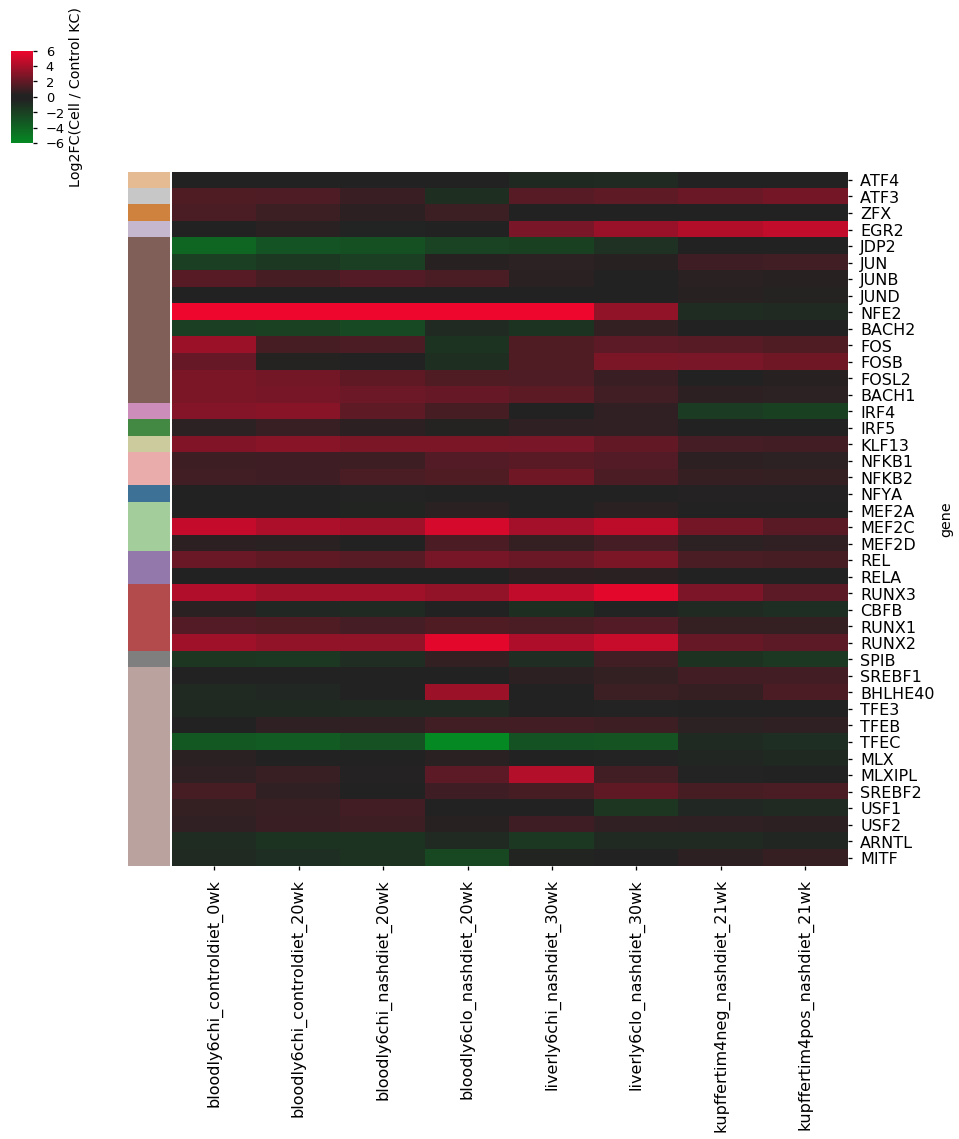

In [23]:
# pal = sns.diverging_palette()
# with sns.color_palette(sns.diverging_palette(10, 120, s=99, l=50)):
log2fc_frame = log2fc_frame.iloc[:, [0,1,2,3,6,7,4,5]]
hm=sns.clustermap(log2fc_frame,
            cmap=sns.diverging_palette(
                130, 10, s=99, l=50,
                center='dark',
                as_cmap=True),
            
            cbar_kws={'label': 'Log2FC(Cell / Control KC)'},
            row_cluster=False,
            col_cluster=False,
            row_colors=[row[1] for row in tf_color_set],
            vmin=-6,
            vmax=6,
            figsize=(15, 15))
plt.setp(hm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=16);
plt.setp(hm.ax_heatmap.xaxis.get_majorticklabels(), rotation=90, fontsize=16);
plt.savefig('./figures/expression_figures/top_motif_expression_heatmap_labeled.pdf', bbox_inches='tight')

heatmap of raw rpkm values

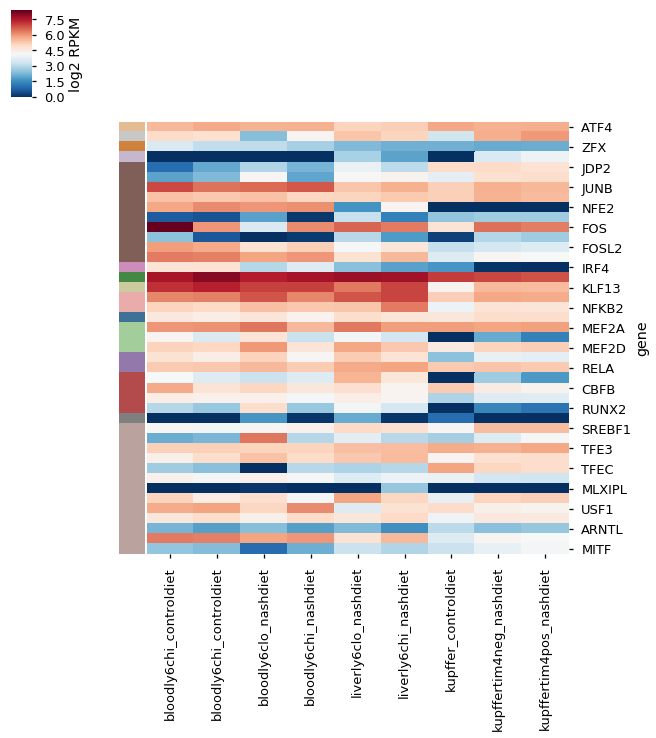

In [24]:
rpkm_temp = np.log2(rpkm_avg_filt.loc[[row[0] for row in tf_color_set], :])
rpkm_temp.columns = rpkm_temp.columns.to_series().str.split('_').str[1:3].str.join('_')

hm=sns.clustermap(rpkm_temp,
            cmap='RdBu_r',
            cbar_kws={'label': 'log2 RPKM'},
            row_cluster=False,
            col_cluster=False,
            row_colors=[row[1] for row in tf_color_set],
            vmin=0,
            figsize=(10,10))

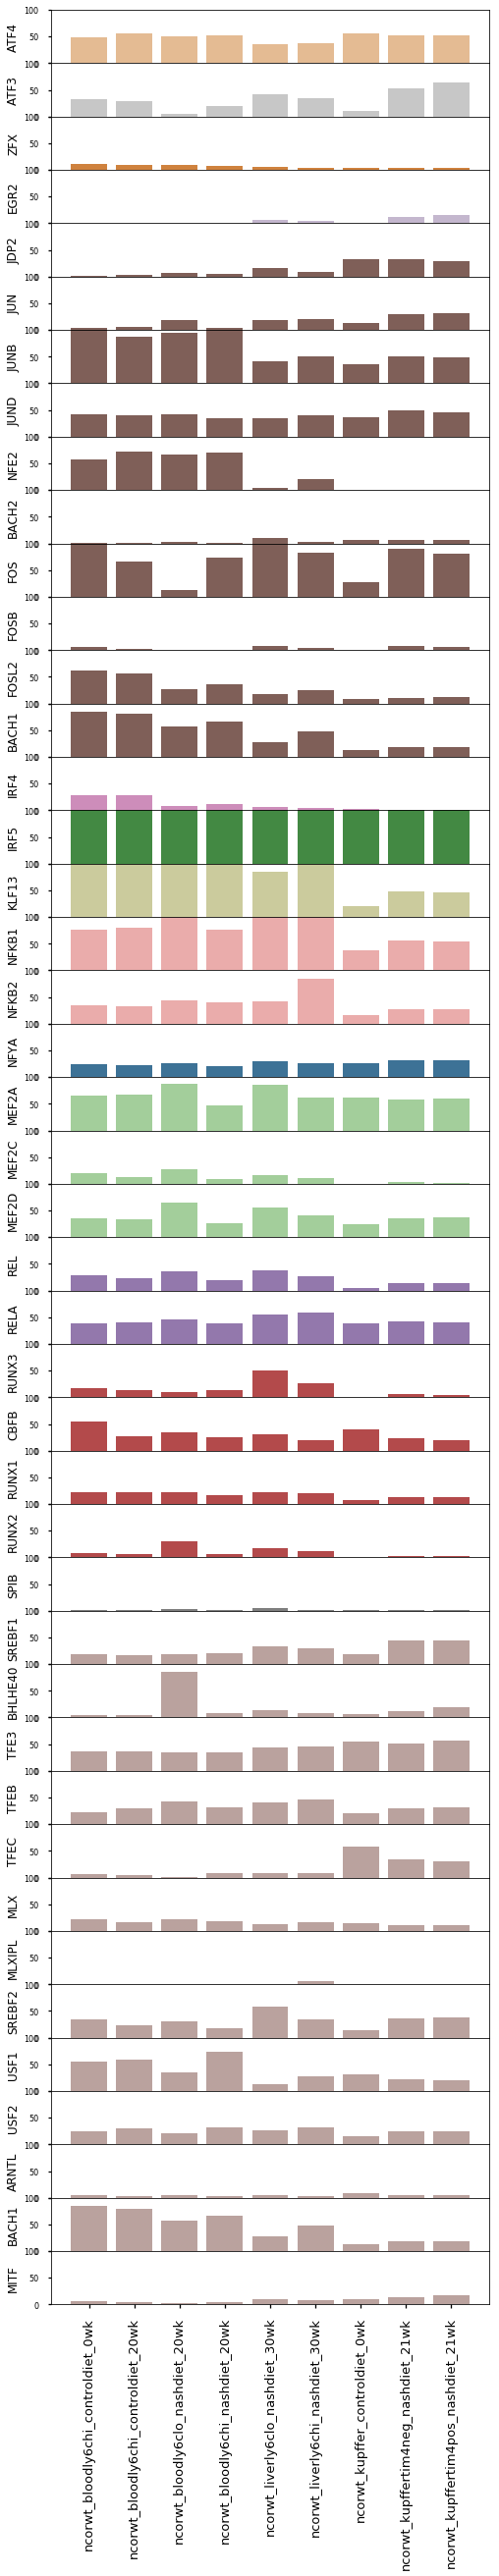

In [25]:
fig, axs = plt.subplots(len(tf_color_set), 1, sharex=True, figsize=(8, len(tf_color_set)))
# remove horizontal space between axis
fig.subplots_adjust(hspace=0)
# iterate through and plot
counter = 0
# remove horizontal space between axis
fig.subplots_adjust(hspace=0)
# iterate through and plot
counter = 0
for gene, color in tf_color_set:
    ind = np.arange(len(rpkm_avg_filt.loc[gene, :]));
    axs[counter].bar(ind, rpkm_avg_filt.loc[gene, :], color=color);
    axs[counter].set_ylabel(gene, fontsize=12);
    axs[counter].set_ylim([0, 100])
    axs[counter].set_xticks(ind);
    axs[counter].set_xticklabels(rpkm_avg_filt.loc[gene, :].index.values, rotation=90)
    axs[counter].tick_params(axis='y', which='major', labelsize=8)
    counter +=1

### Repeat with repopulating monocyte data

In [26]:
# read in rpkm_timecourse
rpkm_timecourse = pd.read_csv('/home/h1bennet/kupffer_timecourse_tba/results/180830_atac/expression/rna_exp_rpkm.tsv', sep='\t')
rpkm_timecourse.set_index(rpkm_timecourse.columns.values[0], inplace=True)
rpkm_timecourse.index.rename('refseqID', inplace=True)
# set rpkm_timecourse index
mm10_gene = rpkm_timecourse['Annotation/Divergence'].str.split('|').str[0]

# clean up column names
# rename rpkm_timecourse columns
rpkm_timecourse = rpkm_timecourse.rename(columns=dict(zip(rpkm_timecourse.iloc[:, 7:].columns.values,
                                    pd.Series(rpkm_timecourse.iloc[:, 7:].columns.values).str[:-5].str.split('/').str[-1])))
# change index to gene names
rpkm_timecourse['gene'] = mm10_gene.str.upper()
rpkm_timecourse = rpkm_timecourse.reset_index().set_index('gene').drop(labels='refseqID', axis=1)

# filter genes with length < 250 bp
rpkm_timecourse = rpkm_timecourse.loc[rpkm_timecourse.Length >= 250, :]
rpkm_timecourse = rpkm_timecourse.iloc[:, 7:]
rpkm_timecourse = rpkm_timecourse.iloc[:, [1,2,3,7,8,11,10,5,6,12,13]]

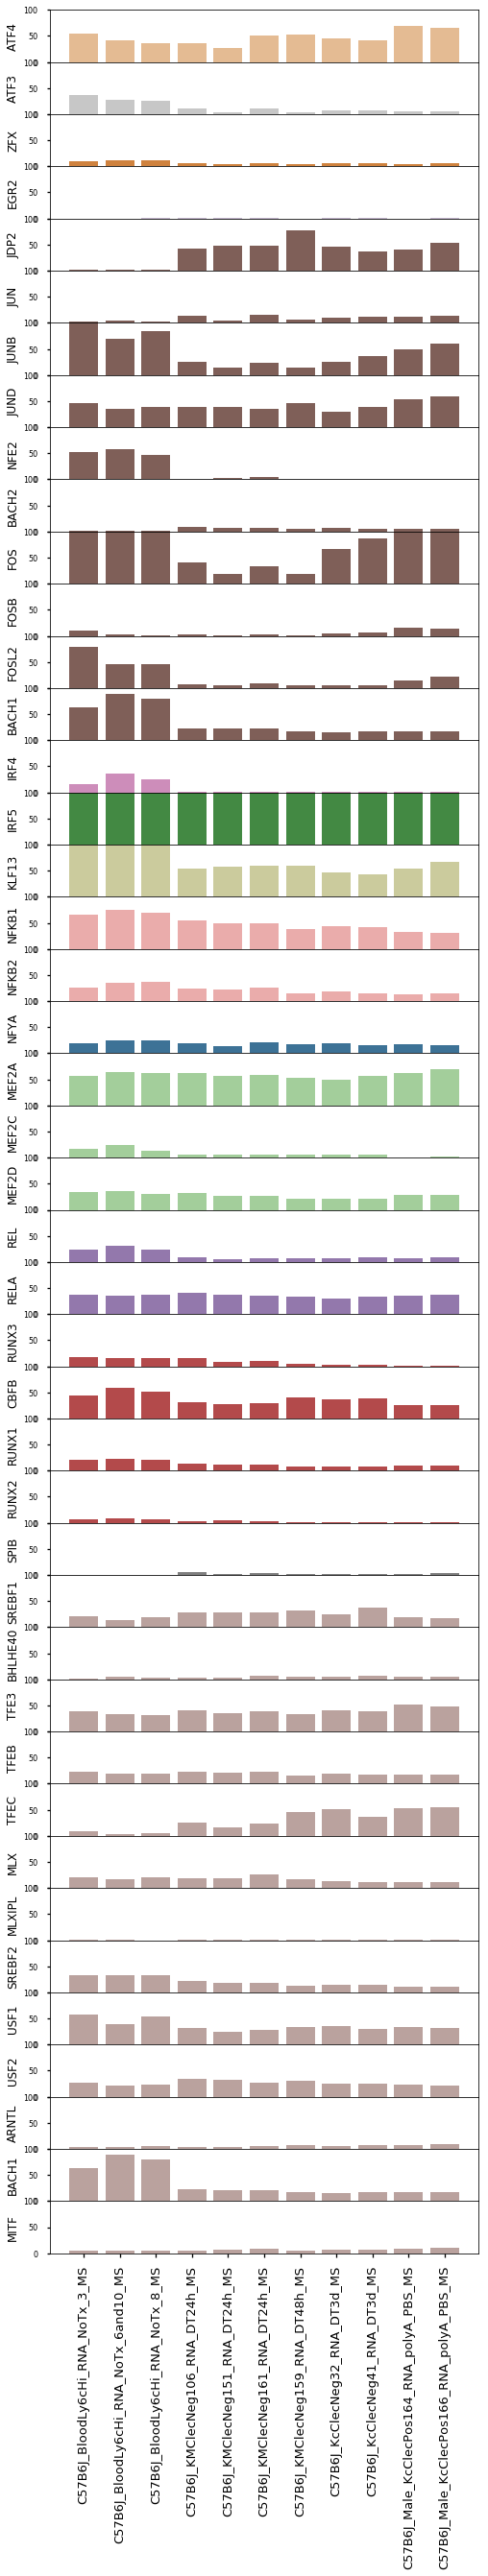

In [27]:
fig, axs = plt.subplots(len(tf_color_set), 1, sharex=True, figsize=(8, len(tf_color_set)))
# remove horizontal space between axis
fig.subplots_adjust(hspace=0)
# iterate through and plot
counter = 0
# remove horizontal space between axis
fig.subplots_adjust(hspace=0)
# iterate through and plot
counter = 0
for gene, color in tf_color_set:
    ind = np.arange(len(rpkm_timecourse.loc[gene, :]));
    axs[counter].bar(ind, rpkm_timecourse.loc[gene, :], color=color);
    axs[counter].set_ylabel(gene, fontsize=12);
    axs[counter].set_ylim([0, 100])
    axs[counter].set_xticks(ind);
    axs[counter].set_xticklabels(rpkm_timecourse.loc[gene, :].index.values, rotation=90)
    axs[counter].tick_params(axis='y', which='major', labelsize=8)
    counter +=1

make individual tf family plots

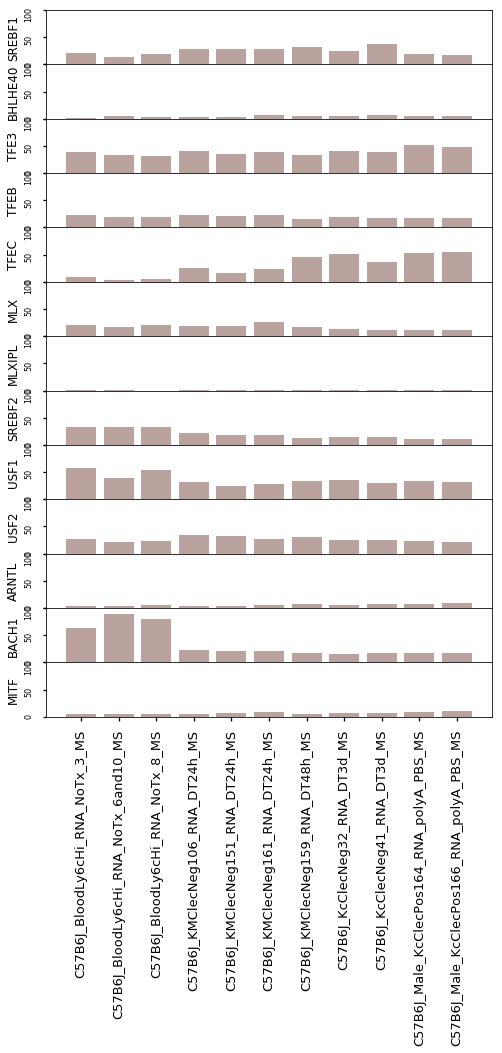

In [28]:
fig, axs = plt.subplots(len(tf_color_set[-13:]), 1, sharex=True, figsize=(8, len(tf_color_set[-13:])))
# remove horizontal space between axis
fig.subplots_adjust(hspace=0)
# iterate through and plot
counter = 0
# remove horizontal space between axis
fig.subplots_adjust(hspace=0)
# iterate through and plot
counter = 0
for gene, color in tf_color_set[-13:]:
    ind = np.arange(len(rpkm_timecourse.loc[gene, :]));
    axs[counter].bar(ind, rpkm_timecourse.loc[gene, :], color=color);
    axs[counter].set_ylabel(gene, fontsize=12);
    axs[counter].set_ylim([0, 100])
    axs[counter].set_xticks(ind);
    axs[counter].set_xticklabels(rpkm_timecourse.loc[gene, :].index.values, rotation=90)
    axs[counter].tick_params(axis='y', which='major', labelsize=8, rotation=90)
    counter +=1

### MA Style Plot

In [29]:
pseudocount = 1e-50 # pseudocount for calculating logfold change
treatments = tf_mean_pval_frame.columns
treatment_orientedPvals_dict = {}
# create treatement oriented p val frame
for treatment in treatments:
    # retrieve pval and weights cooresponding to treatment
    pvals = tf_mean_pval_frame[treatment]
    weights = tf_mean_weight_frame[treatment]
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    # store in dict
    treatment_orientedPvals_dict[treatment] = oriented_pvals

# create data frame
tf_frame = pd.DataFrame(treatment_orientedPvals_dict, index = tf_mean_pval_frame.index.values)

# OPTION: exclude negatively correlated motivs
tf_frame = tf_frame[tf_frame.max(axis=1) > 2]


In [30]:
tf_frame.columns.values

array(['ncorwt_bloodly6chi_controldiet_0wk',
       'ncorwt_bloodly6chi_nashdiet_20wk',
       'ncorwt_bloodly6clo_nashdiet_20wk',
       'ncorwt_kupffer_controldiet_0wk',
       'ncorwt_kupffertim4neg_nashdiet_21wk',
       'ncorwt_kupffertim4pos_nashdiet_21wk',
       'ncorwt_liverly6chi_nashdiet_30wk',
       'ncorwt_liverly6clo_nashdiet_30wk'], dtype=object)

Can also use the homer based frame

In [31]:
homer_mean_pval_frame = pd.read_csv('./tf_mean_pval_homer.tsv', sep='\t', index_col=0)
pseudocount = 1e-50 # pseudocount for calculating logfold change
treatments = homer_mean_pval_frame.columns
treatment_orientedPvals_dict = {}
# create treatement oriented p val frame
for treatment in treatments:
    # retrieve pval and weights cooresponding to treatment
    pvals = homer_mean_pval_frame[treatment]
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [-np.log10(x +pseudocount) for x in pvals]
    # store in dict
    treatment_orientedPvals_dict[treatment] = oriented_pvals

# create data frame
tf_frame_homer = pd.DataFrame(treatment_orientedPvals_dict, index = homer_mean_pval_frame.index.values)

# OPTION: exclude negatively correlated motivs
tf_frame_homer = tf_frame_homer[tf_frame_homer.max(axis=1) > 2]

tf_frame_homer.index = tf_frame_homer.index.to_series().str.split('(').str[0].str.upper()

In [32]:
rpkm_avg.loc['Smad7', :]

ncorwt_bloodly6chi_controldiet_0wk      3.442139
ncorwt_bloodly6chi_controldiet_20wk     2.850021
ncorwt_bloodly6clo_nashdiet_20wk        4.000146
ncorwt_bloodly6chi_nashdiet_20wk        3.250917
ncorwt_liverly6clo_nashdiet_30wk       13.579667
ncorwt_liverly6chi_nashdiet_30wk        7.753514
ncorwt_kupffer_controldiet_0wk         14.845167
ncorwt_kupffertim4neg_nashdiet_21wk    14.530222
ncorwt_kupffertim4pos_nashdiet_21wk    12.488931
Name: Smad7, dtype: float64

Text(0.5,1,'ncorwt_kupffertim4pos_nashdiet_21wk vs. ncorwt_kupffer_controldiet_0wk')

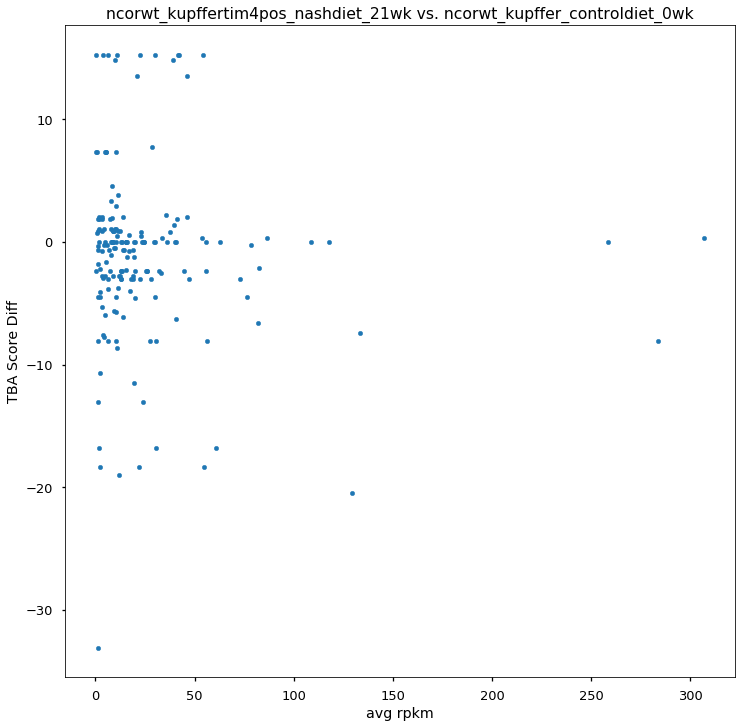

In [33]:
# select samples
samp1='ncorwt_kupffertim4pos_nashdiet_21wk'
samp2='ncorwt_kupffer_controldiet_0wk'

# get average expression and difference in ABTBA p val
avg_exp = (rpkm_avg_filt[samp1] + rpkm_avg_filt[samp2])/2
sig_delta = tf_frame[samp1] - tf_frame[samp2]

# find TFs in both data sets
shared_tfs = set(avg_exp.index).intersection(sig_delta.index)

# make plot
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(
    x=avg_exp[shared_tfs],
    y=sig_delta[shared_tfs],
    s=20)
ax.set_xlabel('avg rpkm')
ax.set_ylabel('TBA Score Diff')
ax.set_title('%s vs. %s' % (samp1, samp2))

# # label top genes
# for tf in shared_tfs:
#     if (np.abs(sig_delta[tf]) >= 4 and avg_exp[tf] >= 20):
#         # print(i, point)
#         ax.text(avg_exp[tf]+0.2,
#                 sig_delta[tf]+0.2,
#                 str(tf),
#                 fontsize=14)

# plt.scatter(
#     x=avg_exp['EGR2'],
#     y=sig_delta['EGR2'],
#     s=15,
#     c='r')

### Compare to HOMER

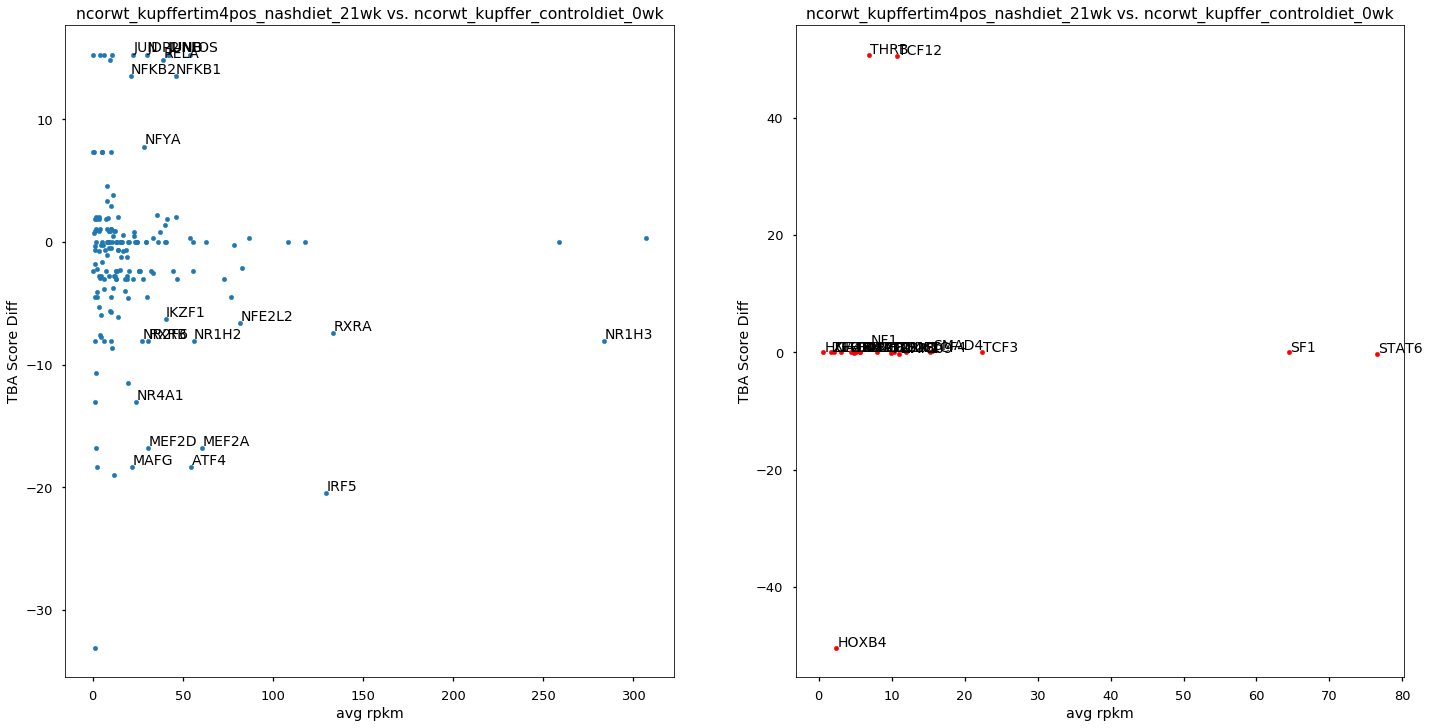

In [34]:
# select samples
samp1='ncorwt_kupffertim4pos_nashdiet_21wk'
samp2='ncorwt_kupffer_controldiet_0wk'

# get average expression and difference in ABTBA p val
avg_exp = (rpkm_avg_filt[samp1] + rpkm_avg_filt[samp2])/2
sig_delta = tf_frame[samp1] - tf_frame[samp2]
sig_delta_homer = tf_frame_homer['_'.join(samp1.split('_')[:-1])]\
        - tf_frame_homer['_'.join(samp2.split('_')[:-1])]

# find TFs in both data sets
shared_tfs = set(avg_exp.index).intersection(sig_delta.index)
shared_tfs_homer = set(avg_exp.index).intersection(sig_delta_homer.index)

# make plot
fig, axs = plt.subplots(1, 2, figsize=(24,12))
axs[0].scatter(
    x=avg_exp[shared_tfs],
    y=sig_delta[shared_tfs],
    s=20)
axs[0].set_xlabel('avg rpkm')
axs[0].set_ylabel('TBA Score Diff')
axs[0].set_title('%s vs. %s' % (samp1, samp2))

# label top genes
for tf in shared_tfs:
    if (np.abs(sig_delta[tf]) >= 5 and avg_exp[tf] >= 20):
        # print(i, point)
        axs[0].text(avg_exp[tf]+0.2,
                sig_delta[tf]+0.2,
                str(tf),
                fontsize=14)
        
# make plot
axs[1].scatter(
    x=avg_exp[shared_tfs_homer],
    y=sig_delta_homer.loc[shared_tfs_homer],
    s=20,
    c='red')
axs[1].set_xlabel('avg rpkm')
axs[1].set_ylabel('TBA Score Diff')
axs[1].set_title('%s vs. %s' % (samp1, samp2))

# label top genes
for tf in shared_tfs_homer:
    #if (np.abs(sig_delta_homer[tf]) >= 5 and avg_exp[tf] >= 20):
        # print(i, point)
    axs[1].text(avg_exp[tf]+0.2,
            sig_delta_homer[tf]+0.2,
            str(tf),
            fontsize=14)
        
# plt.scatter(
#     x=avg_exp['RELA'],
#     y=sig_delta['RELA'],
#     s=15,
#     c='r')

Expression of IRF genes

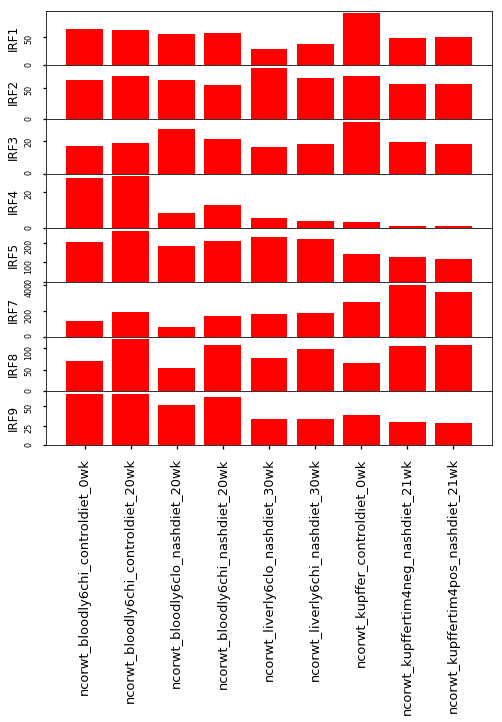

In [35]:
# define expressed IRF genes
irfs = [i for i in rpkm_avg_filt.index.tolist() if ('IRF' in i) and ('BP' not in i)]
irfs.sort()


fig, axs = plt.subplots(len(irfs), 1, sharex=True, figsize=(8, len(irfs)))
# remove horizontal space between axis
fig.subplots_adjust(hspace=0)
# iterate through and plot
counter = 0

for gene in irfs:
    ind = np.arange(len(rpkm_avg_filt.loc[gene, :]));
    axs[counter].bar(ind, rpkm_avg_filt.loc[gene, :], color='red');
    axs[counter].set_ylabel(gene, fontsize=12);
#     axs[counter].set_ylim([0, 200])
    axs[counter].set_xticks(ind);
    axs[counter].set_xticklabels(rpkm_avg_filt.loc[gene, :].index.values, rotation=90)
    axs[counter].tick_params(axis='y', which='major', labelsize=8, rotation=90)
    counter +=1

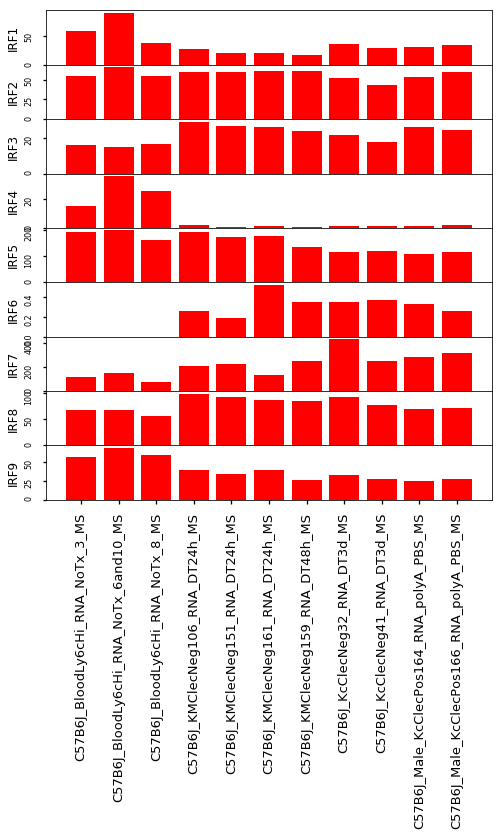

In [36]:
# define expressed IRF genes
irfs = [i for i in rpkm_timecourse.index.tolist() if ('IRF' in i) and ('BP' not in i)]
irfs.sort()


fig, axs = plt.subplots(len(irfs), 1, sharex=True, figsize=(8, len(irfs)))
# remove horizontal space between axis
fig.subplots_adjust(hspace=0)
# iterate through and plot
counter = 0

for gene in irfs:
    ind = np.arange(len(rpkm_timecourse.loc[gene, :]));
    axs[counter].bar(ind, rpkm_timecourse.loc[gene, :], color='red');
    axs[counter].set_ylabel(gene, fontsize=12);
#     axs[counter].set_ylim([0, 200])
    axs[counter].set_xticks(ind);
    axs[counter].set_xticklabels(rpkm_timecourse.loc[gene, :].index.values, rotation=90)
    axs[counter].tick_params(axis='y', which='major', labelsize=8, rotation=90)
    counter +=1

In [38]:
rpkm_avg_filt.columns.tolist()

['ncorwt_bloodly6chi_controldiet_0wk',
 'ncorwt_bloodly6chi_controldiet_20wk',
 'ncorwt_bloodly6clo_nashdiet_20wk',
 'ncorwt_bloodly6chi_nashdiet_20wk',
 'ncorwt_liverly6clo_nashdiet_30wk',
 'ncorwt_liverly6chi_nashdiet_30wk',
 'ncorwt_kupffer_controldiet_0wk',
 'ncorwt_kupffertim4neg_nashdiet_21wk',
 'ncorwt_kupffertim4pos_nashdiet_21wk']

In [49]:
samps

['ncorwt_bloodly6chi_controldiet_0wk',
 'ncorwt_kupffer_controldiet_0wk',
 'ncorwt_kupffertim4neg_nashdiet_21wk',
 'ncorwt_kupffertim4pos_nashdiet_21wk']

In [50]:
ind

array([1, 2, 3, 4])

In [59]:
    ind = np.arange(1.5, len(samps)+1.5, step=1)


In [77]:
# create avg rpkm matrix for filtering
rpkm_std = pd.DataFrame([
    rpkm_quant.loc[:, pd.Series(rpkm_quant.columns).str.contains('NoTx').values].std(1),
    rpkm_quant.loc[:, pd.Series(rpkm_quant.columns).str.contains('BloodLy6cHi_RNA_20wkControlDiet').values].std(1),
    rpkm_quant.loc[:, pd.Series(rpkm_quant.columns).str.contains('BloodLy6cLow_RNA_20wkNASHDiet').values].std(1),
    rpkm_quant.loc[:, pd.Series(rpkm_quant.columns).str.contains('BloodLy6cHi_RNA_20wkNASHDiet').values].std(1),
    rpkm_quant.loc[:, pd.Series(rpkm_quant.columns).str.contains('Ly6cLow_RNA_AMLNDiet').values].std(1),
    rpkm_quant.loc[:, pd.Series(rpkm_quant.columns).str.contains('Ly6cHi_RNA_AMLNDiet').values].std(1),
    rpkm_quant.loc[:, pd.Series(rpkm_quant.columns).str.contains('KupfferTim4Pos_RNA_Control').values].std(1),
    rpkm_quant.loc[:, pd.Series(rpkm_quant.columns).str.contains('Tim4NegKupffer_RNA_AMLNDiet').values].std(1),
    rpkm_quant.loc[:, pd.Series(rpkm_quant.columns).str.contains('Tim4PosKupffer_RNA_AMLNDiet').values].std(1)],
    index=['ncorwt_bloodly6chi_controldiet_0wk',
           'ncorwt_bloodly6chi_controldiet_20wk',
           'ncorwt_bloodly6clo_nashdiet_20wk',
           'ncorwt_bloodly6chi_nashdiet_20wk',
           'ncorwt_liverly6clo_nashdiet_30wk',
           'ncorwt_liverly6chi_nashdiet_30wk',
           'ncorwt_kupffer_controldiet_0wk',
           'ncorwt_kupffertim4neg_nashdiet_21wk',
           'ncorwt_kupffertim4pos_nashdiet_21wk']).T


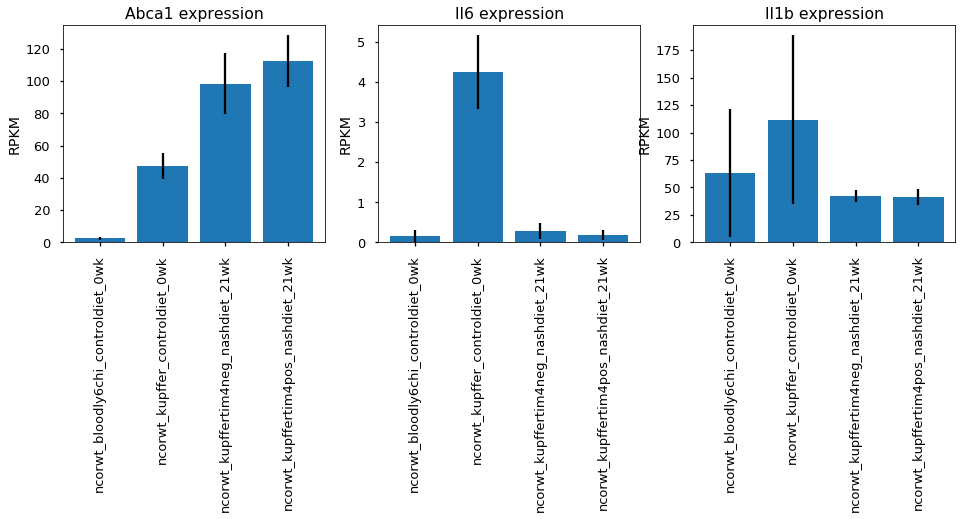

In [80]:
samps = ['ncorwt_bloodly6chi_controldiet_0wk',
         'ncorwt_kupffer_controldiet_0wk',
         'ncorwt_kupffertim4neg_nashdiet_21wk',
         'ncorwt_kupffertim4pos_nashdiet_21wk']
fig, ax = plt.subplots(1, 3, figsize=(16,4))
count=0
for gene in ['Abca1', 'Il6', 'Il1b']:
    ind = np.arange(1, len(samps)+1)
    ax[count].bar(ind,
                  height=rpkm_avg_filt.loc[gene.upper(), samps],
                  align='center',
                  tick_label=samps,
                  yerr=rpkm_std.loc[gene, samps])
    ax[count].set_xticklabels(samps, rotation=90)
    ax[count].set_title(gene+' expression')
    ax[count].set_ylabel('RPKM')
    count+=1